# BooksNN - Look at Raw Keepa Data, and Preprocess

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyisbn #module for converting ISBN-13 to ISBN-10 and vice versa
import booksnn as bnn

## Pull data from the  database
Keepa data for tracked items is stored in a local sqlite database to avoid redundant queries that cost tokens. The default location is r"C:\sqlite\db\keepadb.db" but a different location can be passed as an argument to any function that accesses the database. 

### Get list of ASINs from the sqlite database. 
The ASIN is used as the ID of every product. 

USE CAUTION WHEN LOADING ALL DATA! 500 ASINS ALREADY TAKES A FEW MINUTES TO LOAD. 

In [2]:
asins_in_db = bnn.get_asin_list()
print('Total number of ASINs in database: ' + str(len(asins_in_db))+'\n')
asins = asins_in_db[0:-1] #select a subset if desired

print('First 100 ASINs:')
print(asins[0:100])

Total number of ASINs in database: 577

First 100 ASINs:
['0321879724', '0757552013', '1118452283', '007337931X', '0073385379', '0073398276', '007340683X', '0073519537', '007742171X', '0078028221', '0078035333', '0130909963', '0131118927', '0131860615', '0132163640', '0132543036', '0132576279', '0132685884', '0133594149', '0133823903', '0133840549', '013404228X', '013410398X', '0134203143', '0134217454', '0134261925', '0134293932', '013429601X', '0134319656', '0134454170', '0134484142', '0135151031', '0136042597', '0136058280', '0199321388', '0205149766', '0205608396', '0321295358', '0321715357', '0321775651', '0321809262', '0321839927', '0321909100', '0321910419', '0321925122', '0321927044', '0321962753', '032196957X', '0321976495', '0321998596', '0393265943', '0393933857', '0470262842', '0470888644', '0495391328', '0495561983', '0757588913', '0792383931', '0840028644', '0879500034', '1111578702', '1111827052', '1118170512', '1118324579', '1118486897', '1118539710', '1133109039', '113

### Get time series data from the database. 
Warning: this may take a long time!

Access the time series by specifying the ASINs of interest. 

Used price, used count and salesrank are the most influential series so that's all we pull from the database for now. Other series that Keepa provides, such as New price, List price, etc, is all stored in the database as well. 

In [3]:
up_dict = bnn.get_usedprice(asins)
uc_dict = bnn.get_usedcount(asins)
sr_dict = bnn.get_salesrank(asins)

## View time series
#### One product: Used price, used count, and salesrank

<AxesSubplot:title={'center':'Used price history of ASIN 0321879724'}, xlabel='Datetime'>

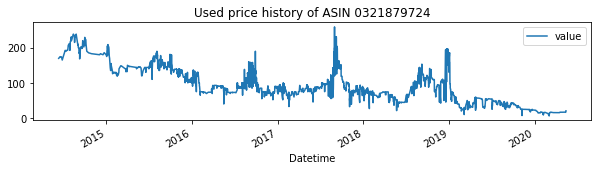

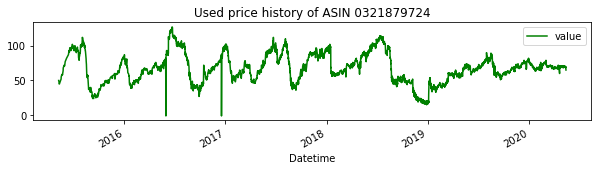

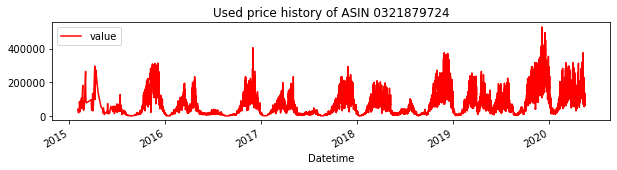

In [4]:
list(up_dict.values())[0].plot(title='Used price history of ASIN ' + list(up_dict.keys())[0],figsize=(10,2))
list(uc_dict.values())[0].plot(title='Used price history of ASIN ' + list(uc_dict.keys())[0],figsize=(10,2),color='green')
list(sr_dict.values())[0].plot(title='Used price history of ASIN ' + list(sr_dict.keys())[0],figsize=(10,2),color='red')

## View how the raw data series differ

### Differences in list lengths

Text(0.5, 1.0, 'Salesrank series length')

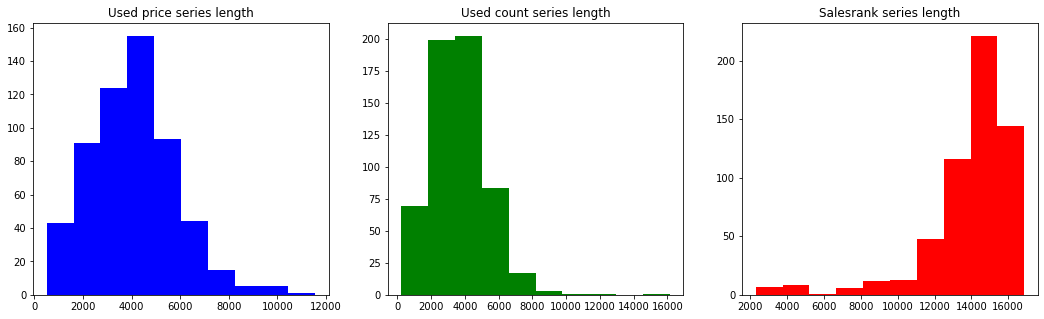

In [5]:
#View difference in list lengths
fig = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.hist([ts.size for ts in up_dict.values()],color='blue')
plt.title('Used price series length')
plt.subplot(1, 3, 2)
plt.hist([ts.size for ts in uc_dict.values()],color='green')
plt.title('Used count series length')
plt.subplot(1, 3, 3)
plt.hist([ts.size for ts in sr_dict.values()],color='red')
plt.title('Salesrank series length')

### Differences in start dates
In the future, consider using plotly: https://plotly.com/python/time-series/

#### Used price start dates

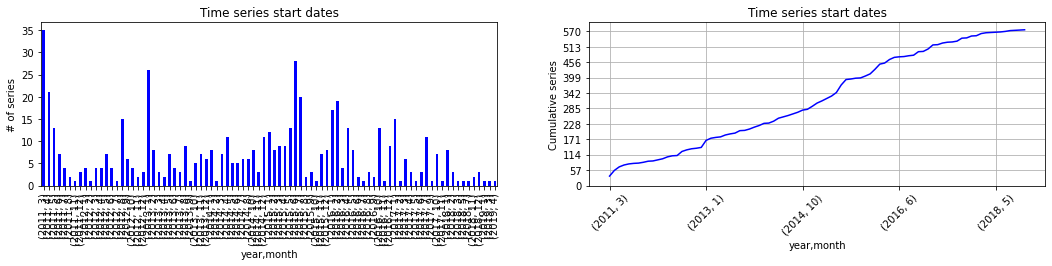

In [6]:
bnn.plot_start_dates([up_dict],plot_color='blue')

#### Used count start dates

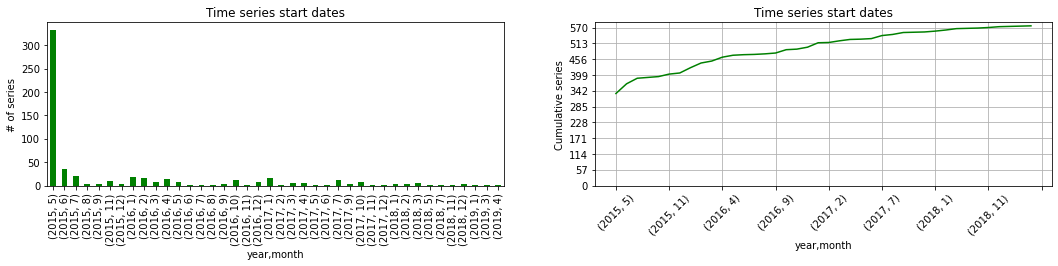

In [7]:
bnn.plot_start_dates([uc_dict],plot_color='green')

#### Salesrank start dates

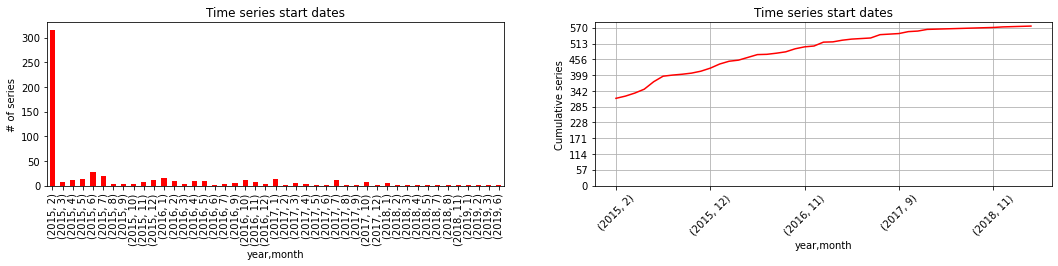

In [8]:
bnn.plot_start_dates([sr_dict],plot_color='red')

#### All series start dates

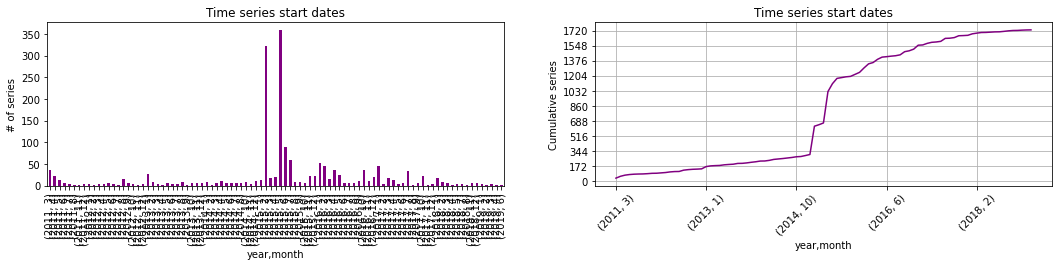

In [9]:
bnn.plot_start_dates([up_dict,uc_dict,sr_dict],plot_color='purple')

Based on the above data, it looks unwise to start any earlier than May 2015 if trimming all time series to the same start date. Furthermore, it's important to note that time series for the same ASINs have different start dates, as some values (namely, used price) was tracked for a much longer time. 

### View data value frequency
What is the distribution of each series?

At this point it's going to be much easier to rearrange the data into a single dataframe with uniform start/end dates and sample frequencies. (Technically I checked in Matlab previously that this doesn't ruin the data but if doing this over rigorously it should be checked).

Some data is discarded when trimming to the desired start/end dates. 

In [10]:
startdate = '2016-01-01'
enddate = '2020-05-10'

# Change dict of dataframes to single dataframe and trim to specified start/end dates
up_df = bnn.dicts_to_dataframe(up_dict,startdate,enddate)
uc_df = bnn.dicts_to_dataframe(uc_dict,startdate,enddate)
sr_df = bnn.dicts_to_dataframe(sr_dict,startdate,enddate)

#### Histograms

<AxesSubplot:title={'center':'Salesrank'}>

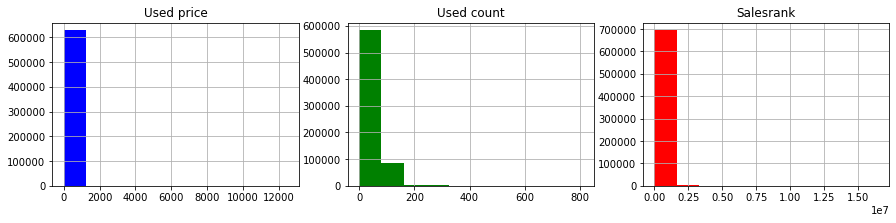

In [11]:
fig = plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1).set_title('Used price')
up_df.stack().hist(color='blue')
plt.subplot(1, 3, 2).set_title('Used count')
uc_df.stack().hist(color='green')
plt.subplot(1, 3, 3).set_title('Salesrank')
sr_df.stack().hist(color='red')


None of these plots look good, due to the presence of outliers. Could transform to log scale if high valued datapoints are significant, but I know from experience that they are spurious/unnecessary and can be capped. Realistic values are used price up to 350, used count up to 200, salesrank up to 2M. 

In [12]:
up_df[up_df>350]=350
uc_df[uc_df>200]=200
sr_df[sr_df>2000000] = 2000000

<AxesSubplot:>

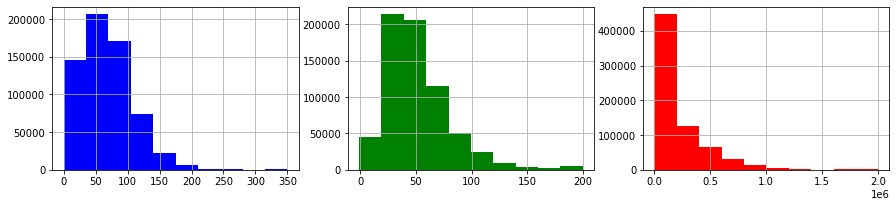

In [13]:
fig = plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
up_df.stack().hist(color='blue')
plt.subplot(1, 3, 2)
uc_df.stack().hist(color='green')
plt.subplot(1, 3, 3)
sr_df.stack().hist(color='red')

Better. Salesrank looks like it could use log transformation. 

<AxesSubplot:>

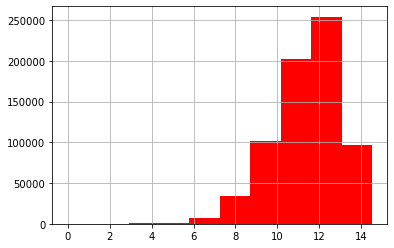

In [14]:
sr_df=sr_df.apply(np.log)
sr_df.stack().hist(color='red')

# Inverse of log is exponent, done like this: 
# sr_df = sr_df.apply(np.exp)

Log of salesrank looks better! 

## Plot average trends 
Used price, used count, and salesrank, respectively. Note - these look much crappier if outliers aren't removed.  

Realistic values are used price up to 350, used count up to 200, salesrank up to 2M. 

Note that scikit-learn has some outlier detection methods that will generalize better to new time series: https://scikit-learn.org/stable/modules/outlier_detection.html

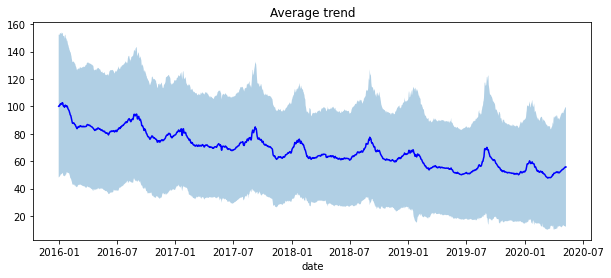

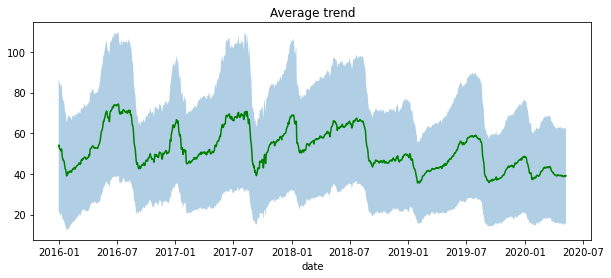

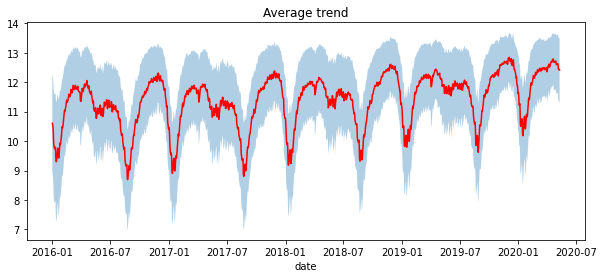

In [15]:
bnn.plot_average(up_df)
bnn.plot_average(uc_df,plot_color='green')
bnn.plot_average(sr_df,plot_color='red')

#### Quick view of statistics of each series

In [16]:
up_df.describe()

,0321879724,0757552013,1118452283,007337931X,0073385379,0073398276,007340683X,0073519537,007742171X,0078028221,...,1319015883,1429234148,1429294760,1451130600,1464108803,1464109362,1464154384,1464183953,1464188033,B000PAU2VW
count,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,...,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000
mean,70.731130,70.357435,57.307090,82.692843,51.490739,106.293226,46.847747,47.988612,118.042208,115.528190,...,71.558882,64.454727,31.203736,47.414417,53.863919,27.340147,71.656360,103.461169,64.337671,1.370900
std,34.201572,9.698555,32.197723,34.529787,16.586798,41.100973,20.500254,26.107462,32.532273,42.934953,...,27.245090,27.913726,18.918410,29.571372,37.488072,22.682683,24.063299,37.201708,12.231586,0.588624
min,7.390000,22.210000,7.157500,21.057500,21.396667,27.790000,11.500000,7.937500,49.691250,56.073333,...,13.422000,14.942500,2.100000,2.367000,2.630000,3.880000,24.666667,47.430000,37.211429,0.010000
25%,44.911667,60.990000,26.464167,53.949375,38.668333,74.753750,29.737500,29.877500,95.552500,89.568000,...,52.355143,43.721250,14.006250,13.193333,15.024000,11.958571,50.359000,80.084091,54.730833,1.150000
50%,72.965000,72.847143,52.445000,75.660000,48.648154,95.897455,43.874286,40.410000,118.887500,104.845000,...,73.392727,58.705000,33.015000,51.430000,51.766667,22.333333,74.908000,93.116774,66.290000,1.500000
75%,89.181667,77.987500,82.965833,110.633681,62.286875,131.062333,57.895446,63.455000,141.333083,125.000000,...,89.409667,77.605000,45.613333,74.840833,90.192500,37.654167,90.541667,116.639250,71.881613,1.804853
max,194.380000,117.851667,170.902727,164.753333,107.548182,209.928750,156.576000,162.380000,224.435000,287.425000,...,200.380000,193.718000,87.430000,101.696667,118.280000,350.000000,134.000000,298.420000,179.320000,2.500000


## Save average series to csv for quick loading

These are average series with outliers removed and log of salesrank used. They are not detrended or scaled. 

In [17]:
'''
# Uncomment this section to save stats
pd.DataFrame(sr_df.mean(axis=1),columns=['mean']).\
    join(pd.DataFrame(sr_df.std(axis=1),columns=['std'])).\
    to_csv('./stats/salesrank_stats_2020_12_05.csv',index_label='index')

pd.DataFrame(uc_df.mean(axis=1),columns=['mean']).\
    join(pd.DataFrame(uc_df.std(axis=1),columns=['std'])).\
    to_csv('./stats/usedcount_stats_2020_12_05.csv',index_label='index')

pd.DataFrame(up_df.mean(axis=1),columns=['mean']).\
    join(pd.DataFrame(up_df.std(axis=1),columns=['std'])).\
    to_csv('./stats/usedprice_stats_2020_12_05.csv',index_label='index')
    
'''

"\n# Uncomment this section to save stats\npd.DataFrame(sr_df.mean(axis=1),columns=['mean']).    join(pd.DataFrame(sr_df.std(axis=1),columns=['std'])).    to_csv('./stats/salesrank_stats_2020_12_05.csv',index_label='index')\n\npd.DataFrame(uc_df.mean(axis=1),columns=['mean']).    join(pd.DataFrame(uc_df.std(axis=1),columns=['std'])).    to_csv('./stats/usedcount_stats_2020_12_05.csv',index_label='index')\n\npd.DataFrame(up_df.mean(axis=1),columns=['mean']).    join(pd.DataFrame(up_df.std(axis=1),columns=['std'])).    to_csv('./stats/usedprice_stats_2020_12_05.csv',index_label='index')\n    \n"

### Normalize
Apply Standard Scaler to transform each series to zero mean and unit variance. Each time series type (up, uc, sr) has its own scaler, which saves parameters to later do an inverse transform. Doing operations on columns only keeps the Datetime index intact. 

Note: more scaling methods, and transformations, can be found here: https://scikit-learn.org/stable/modules/preprocessing.html

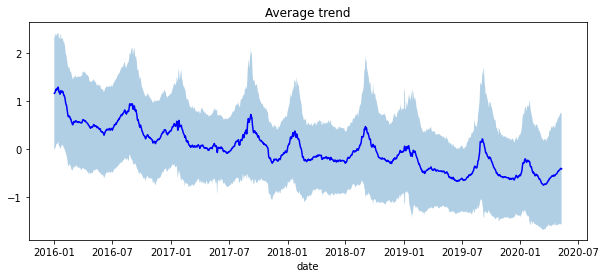

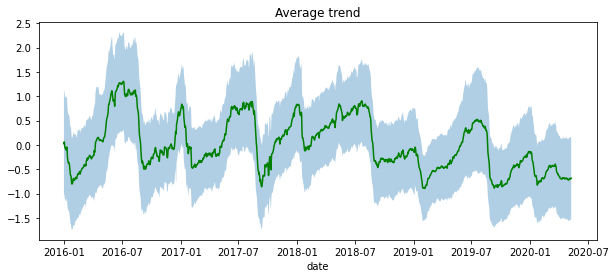

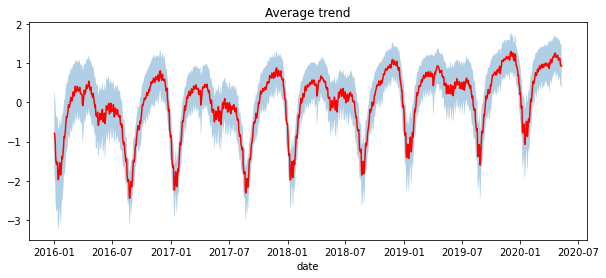

In [18]:
from sklearn.preprocessing import StandardScaler

up_scaler = StandardScaler().fit(up_df[up_df.columns])
up_df[up_df.columns] = up_scaler.transform(up_df[up_df.columns]) #operate only on columns to keep the Datetime index intact

uc_scaler = StandardScaler().fit(uc_df[uc_df.columns])
uc_df[uc_df.columns] = uc_scaler.transform(uc_df[uc_df.columns])

sr_scaler = StandardScaler().fit(sr_df[sr_df.columns])
sr_df[sr_df.columns] = sr_scaler.transform(sr_df[sr_df.columns])

bnn.plot_average(up_df)
bnn.plot_average(uc_df,plot_color='green')
bnn.plot_average(sr_df,plot_color='red')

#### Sanity check: verify inverse transform

In [19]:
'''
#Apply inverse transform and plot
up_df[up_df.columns] = up_scaler.inverse_transform(up_df[up_df.columns])
uc_df[uc_df.columns] = uc_scaler.inverse_transform(uc_df[uc_df.columns])
sr_df[sr_df.columns] = sr_scaler.inverse_transform(sr_df[sr_df.columns])

bnn.plot_average(up_df,fig_size=(10,2))
bnn.plot_average(uc_df,plot_color='green',fig_size=(10,2))
bnn.plot_average(sr_df,plot_color='red',fig_size=(10,2))


# Go back to normal
up_df[up_df.columns] = up_scaler.transform(up_df[up_df.columns]) 
uc_df[uc_df.columns] = uc_scaler.transform(uc_df[uc_df.columns])
sr_df[sr_df.columns] = sr_scaler.transform(sr_df[sr_df.columns])
'''

"\n#Apply inverse transform and plot\nup_df[up_df.columns] = up_scaler.inverse_transform(up_df[up_df.columns])\nuc_df[uc_df.columns] = uc_scaler.inverse_transform(uc_df[uc_df.columns])\nsr_df[sr_df.columns] = sr_scaler.inverse_transform(sr_df[sr_df.columns])\n\nbnn.plot_average(up_df,fig_size=(10,2))\nbnn.plot_average(uc_df,plot_color='green',fig_size=(10,2))\nbnn.plot_average(sr_df,plot_color='red',fig_size=(10,2))\n\n\n# Go back to normal\nup_df[up_df.columns] = up_scaler.transform(up_df[up_df.columns]) \nuc_df[uc_df.columns] = uc_scaler.transform(uc_df[uc_df.columns])\nsr_df[sr_df.columns] = sr_scaler.transform(sr_df[sr_df.columns])\n"

### View first differences

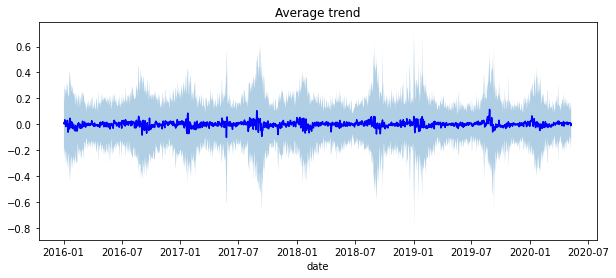

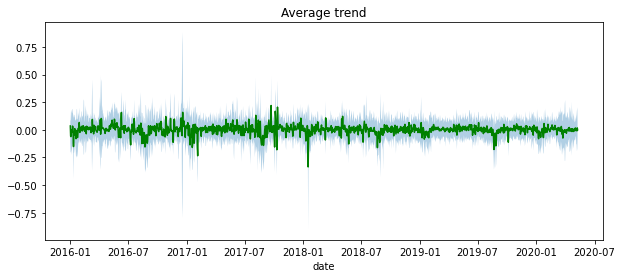

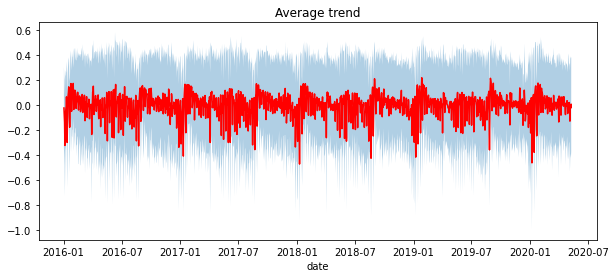

In [20]:
# How to take first differences:
bnn.plot_average(up_df.diff().dropna())
bnn.plot_average(uc_df.diff().dropna(),plot_color='green')
bnn.plot_average(sr_df.diff().dropna(),plot_color='red')